In [228]:
import pandas as pd


def get_stratified_subset(df, label_column, num_examples_per_label, random_state=None):
    """
    Returns a stratified subset of the dataframe with a fixed number of examples for each label.

    Args:
        df (pd.DataFrame): The input dataframe.
        label_column (str): The name of the column containing the labels.
        num_examples_per_label (int): The fixed number of examples to sample for each label.
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A stratified subset of the dataframe.
    """
    if random_state is not None:
        np.random.seed(random_state)

    stratified_subset = []

    for label in df[label_column].unique():
        label_group = df[df[label_column] == label]
        if len(label_group) < num_examples_per_label:
            raise ValueError(f"Not enough examples for label '{label}'. Requested {num_examples_per_label}, but only {len(label_group)} available.")
        
        sampled_group = label_group.sample(n=num_examples_per_label, random_state=random_state)
        stratified_subset.append(sampled_group)

    return pd.concat(stratified_subset).reset_index(drop=True)
def concatenate_dataframes(dfs):
    """
    Concatenates a list of DataFrames based on the 'filename' column as the ID.
    Drops the 'Prediction' column from each DataFrame and returns all column names except 'filename'.

    Parameters:
        dfs (list): List of pandas DataFrames to concatenate. Each must have a 'filename' column.

    Returns:
        pd.DataFrame: A single DataFrame with merged data.
        list: List of all column names excluding 'filename'.
    """
    if not dfs:
        raise ValueError("The list of DataFrames is empty.")

    for df in dfs:
        if 'Filename' not in df.columns:
            raise ValueError("Each DataFrame must contain a 'filename' column.")

    # Drop 'Prediction' column from each DataFrame if it exists
    dfs = [df.drop(columns=['Prediction'], errors='ignore') for df in dfs]

    # Start with the first DataFrame
    result = dfs[0].copy()
    
    for idx, df in enumerate(dfs[1:], start=1):
        # Rename columns to add a suffix except for 'filename'
        renamed_df = df.rename(columns={col: f"{col}_exp{idx}" for col in df.columns if col != 'Filename'})
        
        # Merge with the existing result
        result = pd.merge(result, renamed_df, on='Filename', how='outer')

    # Get all column names except 'filename'
    column_names = [col for col in result.columns if col != 'Filename']

    return result, column_names

In [229]:
import pandas as pd
import numpy as np

In [230]:
experiments_list = [
    'multimodalmodel_w2v2xls2b_robertalarge_lazyload_lr1e4_head1',
    'multimodalmodel_hubertxlarge_robertalarge_lazyload_lr1e4_head1',
    'multimodalmodel_whisperlarge_robertalarge_lazyload_lr1e4_1head',
    'multimodalmodel_wavlmlarge_robertalarge_lazyload_lr1e4_head1',
    'multimodalmodel_w2v2robust_robertalarge_lazyload_lr1e4_head1',
    "multimodalmodel_whisperlarge_debertaxxlarge_lazyload_lr1e5_lasthidden_head1",
    "multimodalmodel_whisperlarge_hubertxlarge_lazyload_lr1e4_head1"
]

dfs = []
dfs_val = []
for exp in experiments_list:
    dfs.append(pd.read_csv(f'../experiments/{exp}/results/train.csv'))
    dfs_val.append(pd.read_csv(f'../experiments/{exp}/results/dev.csv'))
# preds.head()

In [231]:
preds, cols = concatenate_dataframes(dfs)
preds_val, _ = concatenate_dataframes(dfs_val)

In [232]:
preds.head()

,Filename,class_0_prob,class_1_prob,class_2_prob,class_3_prob,class_4_prob,class_5_prob,class_6_prob,class_7_prob,class_0_prob_exp1,...,class_6_prob_exp5,class_7_prob_exp5,class_0_prob_exp6,class_1_prob_exp6,class_2_prob_exp6,class_3_prob_exp6,class_4_prob_exp6,class_5_prob_exp6,class_6_prob_exp6,class_7_prob_exp6
0,MSP-PODCAST_0005_0110.wav,0.0467,-1.3908,-1.9270,-0.1232,-0.4376,1.3934,2.4141,-0.0260,0.6495,...,1.6446,0.7143,-0.6459,-1.3394,-0.4664,-0.3118,-0.9763,0.0663,1.4804,1.0746
1,MSP-PODCAST_0023_0064.wav,-1.8494,-0.4594,-0.1003,-0.5324,-0.8848,0.0798,2.1872,0.9556,-1.1495,...,0.4978,-0.1781,0.3437,0.5059,-1.4051,1.2146,-1.3883,-1.5404,0.8110,0.1797
2,MSP-PODCAST_0023_0179.wav,-0.5292,-0.5492,-0.5473,-0.7944,0.3030,-0.3077,1.2879,0.8922,-0.5645,...,2.0153,0.5828,-0.0208,-2.7570,0.1882,-0.4182,0.2964,-1.5373,1.5591,0.7393
3,MSP-PODCAST_0023_0320.wav,-0.3186,0.0905,-1.6711,0.1705,-2.4125,1.4789,1.8924,0.4987,-0.3674,...,1.0756,0.7353,-0.6430,-0.0076,-0.5034,-1.0032,0.4406,-0.8267,0.6628,0.9406
4,MSP-PODCAST_0023_0386.wav,-0.7226,-0.3260,-0.9338,0.4871,0.0017,0.4451,1.3037,0.3800,0.1489,...,0.9996,0.0355,0.1944,-1.1090,-0.1334,-0.0090,-0.0235,-1.4754,0.5965,0.1148


In [233]:
classes_ = ['A', 'S', 'H', 'U', 'F', 'D', 'C', 'N']

map_idx = dict()
for i, c in enumerate(classes_):
    map_idx[c] = i

map_argmax = dict()
for i, c in enumerate(classes_):
    map_argmax[i] = c

In [234]:
df = pd.read_csv('/workspace/lucas.ueda/interspeech_ser/data/Labels/labels_consensus.csv')
df.head()

,FileName,EmoClass,EmoAct,EmoVal,EmoDom,SpkrID,Gender,Split_Set
0,MSP-PODCAST_0002_0033.wav,N,4.8,4.2,5.4,127,Female,Development
1,MSP-PODCAST_0002_0039.wav,N,4.0,4.2,4.2,127,Female,Development
2,MSP-PODCAST_0002_0051.wav,N,4.0,4.2,4.2,127,Female,Development
3,MSP-PODCAST_0002_0059.wav,X,4.0,3.8,4.0,128,Female,Development
4,MSP-PODCAST_0002_0061.wav,F,3.4,2.8,4.2,128,Female,Development


In [235]:
# Just saving the auxiliardataset

In [236]:
preds['FileName'] = preds['Filename']
preds = preds.merge(df[['FileName','EmoClass','Gender','SpkrID']], how='left', on = 'FileName')

preds_val['FileName'] = preds_val['Filename']
preds_val = preds_val.merge(df[['FileName','EmoClass','Gender','SpkrID']], how='left', on = 'FileName')

In [237]:
preds['target'] = preds['EmoClass'].map(map_idx)
preds_val['target'] = preds_val['EmoClass'].map(map_idx)

In [238]:
preds.head()

,Filename,class_0_prob,class_1_prob,class_2_prob,class_3_prob,class_4_prob,class_5_prob,class_6_prob,class_7_prob,class_0_prob_exp1,...,class_3_prob_exp6,class_4_prob_exp6,class_5_prob_exp6,class_6_prob_exp6,class_7_prob_exp6,FileName,EmoClass,Gender,SpkrID,target
0,MSP-PODCAST_0005_0110.wav,0.0467,-1.3908,-1.9270,-0.1232,-0.4376,1.3934,2.4141,-0.0260,0.6495,...,-0.3118,-0.9763,0.0663,1.4804,1.0746,MSP-PODCAST_0005_0110.wav,H,Male,85,2
1,MSP-PODCAST_0023_0064.wav,-1.8494,-0.4594,-0.1003,-0.5324,-0.8848,0.0798,2.1872,0.9556,-1.1495,...,1.2146,-1.3883,-1.5404,0.8110,0.1797,MSP-PODCAST_0023_0064.wav,H,Male,1,2
2,MSP-PODCAST_0023_0179.wav,-0.5292,-0.5492,-0.5473,-0.7944,0.3030,-0.3077,1.2879,0.8922,-0.5645,...,-0.4182,0.2964,-1.5373,1.5591,0.7393,MSP-PODCAST_0023_0179.wav,F,Male,1,4
3,MSP-PODCAST_0023_0320.wav,-0.3186,0.0905,-1.6711,0.1705,-2.4125,1.4789,1.8924,0.4987,-0.3674,...,-1.0032,0.4406,-0.8267,0.6628,0.9406,MSP-PODCAST_0023_0320.wav,A,Male,1,0
4,MSP-PODCAST_0023_0386.wav,-0.7226,-0.3260,-0.9338,0.4871,0.0017,0.4451,1.3037,0.3800,0.1489,...,-0.0090,-0.0235,-1.4754,0.5965,0.1148,MSP-PODCAST_0023_0386.wav,F,Male,163,4


In [239]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [240]:
preds_estrat = get_stratified_subset(preds, 'EmoClass', 300, random_state=42)

In [241]:
# preds_estrat

In [242]:
# # Just saving the auxiliardataset
# filenames = preds_estrat.FileName

# tmp = pd.read_csv("../benchmark/processed_labels.csv")

In [243]:
# tmp = tmp[tmp['FileName'].isin(filenames)].reset_index(drop=True)
# tmp.shape

In [244]:
# tmp.to_csv("train_stacking_sample.csv")

In [245]:
# tmp.head()

In [246]:
preds_estrat.EmoClass.value_counts()

EmoClass
H    300
F    300
A    300
C    300
N    300
D    300
S    300
U    300
Name: count, dtype: int64

In [247]:
preds_estrat.Gender.value_counts()

Gender
Male      1375
Female    1025
Name: count, dtype: int64

In [299]:
# lr = LogisticRegression(random_state = 42, max_iter = 500, C=1,  multi_class='ovr', penalty='l2')
# lr = RandomForestClassifier(random_state = 42, n_estimators = 500, max_depth = 13, min_samples_leaf=5)
lr = SVC(random_state = 42, C = 1, kernel='rbf', gamma = 'scale')

lr.fit(preds_estrat[cols], preds_estrat['target'])

SVC(C=1, random_state=42)

In [300]:
preds_val['Prediction'] = lr.predict(preds_val[cols])
preds_val['Prediction'] = preds_val['Prediction'].map(map_argmax) 

preds_estrat['Prediction'] = lr.predict(preds_estrat[cols])
preds_estrat['Prediction'] = preds_estrat['Prediction'].map(map_argmax) 

In [301]:
preds_val.head()

,Filename,class_0_prob,class_1_prob,class_2_prob,class_3_prob,class_4_prob,class_5_prob,class_6_prob,class_7_prob,class_0_prob_exp1,...,class_4_prob_exp6,class_5_prob_exp6,class_6_prob_exp6,class_7_prob_exp6,FileName,EmoClass,Gender,SpkrID,target,Prediction
0,MSP-PODCAST_0002_0033.wav,-0.5309,-0.2458,0.3321,0.8860,0.2190,-0.6096,0.0435,0.5484,-1.5255,...,1.3440,-1.4271,-0.9826,0.9510,MSP-PODCAST_0002_0033.wav,N,Female,127,7,F
1,MSP-PODCAST_0002_0039.wav,-0.4002,-0.8329,0.6057,0.5029,0.6050,-1.3757,-0.1083,0.6480,-1.1414,...,0.4338,-0.4464,-0.1509,0.2246,MSP-PODCAST_0002_0039.wav,N,Female,127,7,N
2,MSP-PODCAST_0002_0051.wav,-1.2119,0.0838,0.2217,0.1194,-0.0451,-0.4760,0.5950,1.0839,-0.6628,...,-0.5418,-0.3170,-0.3014,1.3358,MSP-PODCAST_0002_0051.wav,N,Female,127,7,N
3,MSP-PODCAST_0002_0061.wav,-0.4291,-0.8196,-0.2584,0.2270,-0.9395,0.2972,1.5520,0.2986,-1.1753,...,0.3608,-0.6804,0.4722,0.4183,MSP-PODCAST_0002_0061.wav,F,Female,128,4,C
4,MSP-PODCAST_0006_0017.wav,-1.6810,0.9330,0.1571,0.2959,1.0096,-0.9140,0.1110,0.5220,-1.9912,...,1.4300,-1.0312,-0.4236,0.5618,MSP-PODCAST_0006_0017.wav,N,Female,127,7,N


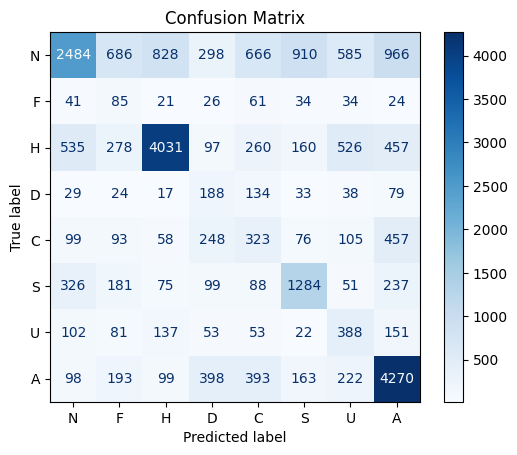

In [302]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(preds_val['EmoClass'], preds_val['Prediction'], labels=preds_val['EmoClass'].unique())

# Display labels
labels = preds_val['EmoClass'].unique()

# Visualize confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [303]:
preds_subset = get_stratified_subset(preds_val, 'EmoClass', 100)
preds_subset.head()

,Filename,class_0_prob,class_1_prob,class_2_prob,class_3_prob,class_4_prob,class_5_prob,class_6_prob,class_7_prob,class_0_prob_exp1,...,class_4_prob_exp6,class_5_prob_exp6,class_6_prob_exp6,class_7_prob_exp6,FileName,EmoClass,Gender,SpkrID,target,Prediction
0,MSP-PODCAST_2421_0197.wav,-0.1429,1.9078,-2.2522,0.2773,-0.5917,0.3216,0.5634,0.1462,0.5336,...,1.4520,-1.9122,0.0203,-0.2465,MSP-PODCAST_2421_0197.wav,N,Female,210,7,S
1,MSP-PODCAST_2347_1004.wav,5.3873,-2.7548,-1.8572,-0.6234,-1.6750,0.3968,1.2889,-1.8675,4.1935,...,0.0834,0.1977,1.1440,-1.4790,MSP-PODCAST_2347_1004.wav,N,Female,210,7,A
2,MSP-PODCAST_3406_0004_0003.wav,-0.5038,-0.7409,0.7005,-0.6081,0.1385,-0.6309,-0.0234,0.3116,-1.3492,...,0.2275,-2.1435,-0.5567,0.6260,MSP-PODCAST_3406_0004_0003.wav,N,Male,1767,7,N
3,MSP-PODCAST_0807_1720.wav,-1.9514,-1.5792,2.3005,2.8567,-1.5613,-1.5856,0.0751,1.4576,-2.1952,...,-1.1132,-0.9354,0.6544,0.6132,MSP-PODCAST_0807_1720.wav,N,Male,97,7,U
4,MSP-PODCAST_3079_1429.wav,-2.2008,2.4689,-0.1923,-0.0080,-0.6137,-1.0631,-0.2149,2.6420,-2.6322,...,-1.3977,-2.0196,-1.6459,2.2442,MSP-PODCAST_3079_1429.wav,N,Male,2261,7,N


# Training bootstrap

In [304]:
# Average F1-score using bootstrap
f1_scores = []
for i in range(100):
    preds_subset = get_stratified_subset(preds_estrat, 'EmoClass', 100, i)
    f1_scores.append(f1_score(preds_estrat['EmoClass'], preds_estrat['Prediction'], average='macro'))

In [305]:
f1_scores = np.array(f1_scores)

np.mean(f1_scores), np.std(f1_scores),np.max(f1_scores),np.min(f1_scores)

(0.6882375033585886,
 3.3306690738754696e-16,
 0.6882375033585882,
 0.6882375033585882)

In [306]:
f1_score(preds_estrat['EmoClass'], preds_estrat['Prediction'], average='macro')

0.6882375033585882

In [307]:
accuracy_score(preds_estrat['EmoClass'], preds_estrat['Prediction'])

0.69

# Dev bootstrap

In [308]:
# Average F1-score using bootstrap
f1_scores = []
for i in range(100):
    preds_subset = get_stratified_subset(preds_val, 'EmoClass', 200, i)
    f1_scores.append(f1_score(preds_subset['EmoClass'], preds_subset['Prediction'], average='macro'))

In [309]:
# f1_scores

In [310]:
f1_scores = np.array(f1_scores)

np.mean(f1_scores), np.std(f1_scores),np.max(f1_scores),np.min(f1_scores)

(0.4238527498269292,
 0.009681258838977308,
 0.44909127126266035,
 0.39177252853276245)

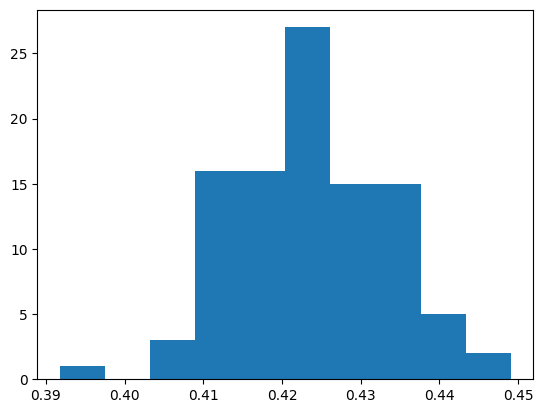

In [311]:
plt.hist(f1_scores, bins=10)
plt.show()

In [312]:
f1_score(preds_val['EmoClass'], preds_val['Prediction'], average='macro')

0.3835853405321236

In [313]:
f1_score(preds_val['EmoClass'], preds_val['Prediction'], average='micro')

0.5167867606302954

In [314]:
accuracy_score(preds_val['EmoClass'], preds_val['Prediction'])

0.5167867606302954

In [315]:
f1_score(preds_val[preds_val['Gender']=='Female']['EmoClass'], preds_val[preds_val['Gender']=='Female']['Prediction'], average='macro')

0.3587398737171242

In [316]:
f1_score(preds_val[preds_val['Gender']=='Male']['EmoClass'], preds_val[preds_val['Gender']=='Male']['Prediction'], average='macro')

0.4006480873675678

In [317]:
accuracy_score(preds_val[preds_val['Gender']=='Female']['EmoClass'], preds_val[preds_val['Gender']=='Female']['Prediction'])

0.456143434698541

In [318]:
accuracy_score(preds_val[preds_val['Gender']=='Male']['EmoClass'], preds_val[preds_val['Gender']=='Male']['Prediction'])

0.5664985590778098

In [319]:
for e in preds['EmoClass'].unique():
    acc = accuracy_score(preds_val[preds_val['EmoClass']==e]['EmoClass'], preds_val[preds_val['EmoClass']==e]['Prediction'])
    print(f'Emotion {e} acc = {acc}')

Emotion H acc = 0.6354035308953342
Emotion F acc = 0.2607361963190184
Emotion A acc = 0.731665524331734
Emotion C acc = 0.2213845099383139
Emotion N acc = 0.3346355920786744
Emotion D acc = 0.34686346863468637
Emotion S acc = 0.5484835540367364
Emotion U acc = 0.39311043566362713


In [320]:
preds_val.EmoClass.value_counts()

EmoClass
N    7423
H    6344
A    5836
S    2341
C    1459
U     987
D     542
F     326
Name: count, dtype: int64

In [321]:
preds_val.Prediction.value_counts(normalize=True)

Prediction
A    0.262927
H    0.208488
N    0.147043
S    0.106184
C    0.078312
U    0.077164
F    0.064178
D    0.055705
Name: proportion, dtype: float64

In [323]:
import joblib

# Save to a file
# joblib.dump(lr, '../submissions/svm_model_stackingv2_augmented.pkl')

['../submissions/svm_model_stackingv2_augmented.pkl']